### MCLP 함수

In [1]:
import numpy as np
from scipy.spatial import distance_matrix
from gurobipy import *
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon, Point
from numpy import random
import time
import pandas as pd
import geopandas as gpd
import random
from haversine import haversine

In [2]:
# 가중치 도보+자전거 0.601  버스 0.311, 0.088 지하철 
m1= 0.311
m2= 0.088
m3= 0.601

In [3]:
def mclp(버스_points, 지하철_points,주택_points, K, radius):

    print('  K %g' % K)
    print('  Radius %g' % radius)

    start = time.time()
    sites = np.array([list(i) for i in zip(sites_df['latitude'], sites_df['longitude'])])
    J = sites.shape[0]                             
    
    # 수요지점 수
    A = 버스_points.shape[0]
    B = 지하철_points.shape[0]
    C = 주택_points.shape[0]
    
    # 입지후보지와 수요지점 간 거리 계산
    D1 = []
    for i in 버스_points:
        site = []
        for j in sites:
            site.append(haversine(i, j, unit='m'))
        D1.append(site)
    D1 = np.array(D1)
    
    D2 = []
    for i in 지하철_points:
        site = []
        for j in sites:
            site.append(haversine(i, j, unit='m'))
        D2.append(site)
    D2 = np.array(D2)    
    

    
    D3 = []
    for i in 주택_points:
        site = []
        for j in sites:
            site.append(haversine(i, j, unit='m'))
        D3.append(site)
    D3 = np.array(D3)

    for i in [D1, D2, D3]:
        mask1 = i<=radius
        i[mask1]=1                                                 
        i[~mask1]=0

    m = Model()
    x1, x2, x3 = {}, {}, {}
    y = {}
    
    # 수요지점 변수 추가
    for i in range(A):                                       
        x1[i] = m.addVar(vtype=GRB.BINARY, name="x1%d" % i)
    for i in range(B):                                       
        x2[i] = m.addVar(vtype=GRB.BINARY, name="x2%d" % i)
    
    for i in range(C):                                       
        x3[i] = m.addVar(vtype=GRB.BINARY, name="x3%d" % i)
    
    # 입지후보지 변수 추가
    for j in range(J):
        y[j] = m.addVar(vtype=GRB.BINARY, name="y%d" % j)

    m.update()
    m.addConstr(quicksum(y[j] for j in range(J)) == K) 

    # 수요지점 제약 조건
    for i in range(A): 
        m.addConstr(quicksum(y[j] for j in np.where(D1[i]==1)[0]) >= x1[i])
    for i in range(B): 
        m.addConstr(quicksum(y[j] for j in np.where(D2[i]==1)[0]) >= x2[i])
    
    for i in range(C): 
        m.addConstr(quicksum(y[j] for j in np.where(D3[i]==1)[0]) >= x3[i])
    
    # 목적함수 수정
    m.setObjective(quicksum(i for i in [m1*x1[a] for a in range(A)] + [m2*x2[b] for b in range(B)]  + [m3*x3[c] for c in range(C)]), GRB.MAXIMIZE)


    m.setParam('OutputFlag', 0)
    m.optimize()
    end = time.time()
    print('----- Output -----')
    print('  Running time : %s seconds' % float(end-start))
    print('Optimal coverage points: %g' % m.objVal)

    solution = []
    if m.status == GRB.Status.OPTIMAL:
        for v in m.getVars():
            if v.x==1 and v.varName[0]=="y":
                solution.append(int(v.varName[1:]))
    opt_sites = sites[solution]
    return opt_sites,m.objVal

### 1. 구월동

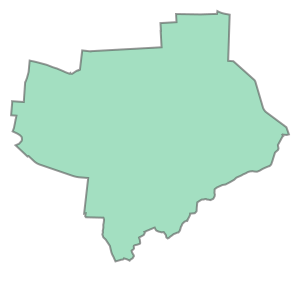

In [4]:
path= 'C:/Users/chldy/OneDrive/바탕 화면/용용/딥러닝 부트캠프/교육데이터공모전/shp_file/'
ex= path+'행정구역_읍면동.shp'
gpff= gpd.read_file(ex)
gpff['geometry'][43]

In [5]:
#랜덤 좌표 생성
def generate_candidate_sites_from_shp(shp_file_path, exclusion_shp_paths, M=100):
    # 대상 .shp 파일에서 폴리곤 불러오기
    random.seed(42)
    gdf = gpd.read_file(shp_file_path)
    poly = gdf['geometry'][43]  # 대상 폴리곤 추출
    
    #제외할 .shp 파일들에서 폴리곤들 불러오기
    ex_poligon_list=[]
    for ex_path in exclusion_shp_paths:
        ex= gpd.read_file(ex_path)
        for ex_poly in ex['geometry']:
            ex_poligon_list.append(ex_poly)
    
    

    min_x, min_y, max_x, max_y = poly.bounds
    sites = []
    attempts = 0  # 시도 횟수
    while len(sites) < M:
        random_point = Point(random.uniform(min_x, max_x),
                             random.uniform(min_y, max_y))
        
        # 진행도 체크
        if attempts % 1000 == 0:  # 100번의 시도마다 진행 상황 출력
            print(f"시도 횟수: {attempts}, 유효한 사이트 수: {len(sites)}")

        # 대상 폴리곤 내에 있고 제외할 폴리곤들 내에 없는지 확인
        if random_point.within(poly) :
            if not any(random_point.within(ex_poly) for ex_poly in ex_poligon_list):
                sites.append(random_point)
        attempts += 1  # 시도 횟수 증가

    return np.array([(p.x, p.y) for p in sites])

# 사용 예시
path= 'C:/Users/chldy/OneDrive/바탕 화면/용용/딥러닝 부트캠프/교육데이터공모전/shp_file/'
shp_file_path = path+'행정구역_읍면동.shp'
exclusion_shp_paths = [path+'상습침수구역.shp', path+'개발제한구역.shp', path+'공항_소음대책지역.shp']  # 제외할 .shp 파일들의 경로 리스트
M = 200  # 생성할 좌표 수
sites = generate_candidate_sites_from_shp(shp_file_path, exclusion_shp_paths ,M)
print(sites)

sites_df= pd.DataFrame(data=sites, columns=['경도','위도'])
sites_df


시도 횟수: 0, 유효한 사이트 수: 0
[[173704.59940187 537914.85919888]
 [175222.85237004 539259.28219382]
 [173519.05854499 538751.31130814]
 [174937.96139796 538868.66942907]
 [173524.98968072 539000.07396382]
 [175451.02381478 539322.84342833]
 [175588.1447977  539042.9434368 ]
 [175455.33080491 539416.50294677]
 [174045.1555244  538889.71573159]
 [175528.6253996  539086.80123641]
 [175634.9073957  538964.75481799]
 [174891.240061   538334.71332298]
 [174931.87757783 539058.96714576]
 [173362.77452686 539414.70938347]
 [173337.32074917 538378.06577833]
 [174632.18427563 539282.74648077]
 [173837.60303276 538046.87425186]
 [174956.23612006 538426.02287517]
 [174646.72182496 538032.05331059]
 [174723.11406242 539914.82961153]
 [174113.81002013 537903.32687925]
 [176081.82254301 538763.67676553]
 [173160.45947087 539113.26431551]
 [175042.6762386  538845.03797706]
 [173677.6058791  539153.33343381]
 [173166.72093322 538542.03848783]
 [174446.73460055 537782.75900255]
 [173781.64184606 539147.3677127

,경도,위도
0,173704.599402,537914.859199
1,175222.852370,539259.282194
2,173519.058545,538751.311308
3,174937.961398,538868.669429
4,173524.989681,539000.073964
...,...,...
195,172921.491176,538742.227295
196,174741.521090,539831.456804
197,174530.191363,538607.742896
198,173913.634430,539306.731308


In [6]:
from pyproj import Proj, transform

# 좌표 변환 함수 정의
def convert_coords(x, y):
    proj_UTM = Proj(init='epsg:5186')  # 원본 좌표계
    proj_WGS84 = Proj(init='epsg:4326')  # 목표 좌표계
    lon, lat = transform(proj_UTM, proj_WGS84, x, y)
    return pd.Series([lat, lon])

    # 새로운 'latitude'와 'longitude' 컬럼을 생성하고 변환된 좌표를 적용
sites_df[['latitude', 'longitude']] = sites_df.apply(lambda row: convert_coords(row['경도'], row['위도']), axis=1)

print(sites_df)

c:\Users\chldy\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\chldy\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\chldy\AppData\Local\Temp\ipykernel_18120\519013629.py:7: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pypro

                경도             위도   latitude   longitude
0    173704.599402  537914.859199  37.440257  126.702863
1    175222.852370  539259.282194  37.452412  126.719974
2    173519.058545  538751.311308  37.447788  126.700737
3    174937.961398  538868.669429  37.448885  126.716768
4    173524.989681  539000.073964  37.450029  126.700795
..             ...            ...        ...         ...
195  172921.491176  538742.227295  37.447689  126.693984
196  174741.521090  539831.456804  37.457554  126.714515
197  174530.191363  538607.742896  37.446523  126.712168
198  173913.634430  539306.731308  37.452803  126.705176
199  174937.804173  539778.286236  37.457080  126.716735

[200 rows x 4 columns]


c:\Users\chldy\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\chldy\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\chldy\AppData\Local\Temp\ipykernel_18120\519013629.py:7: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pypro

In [7]:
# 아파트 좌표
apt= pd.read_csv('교육 공모전 자료/인천_아파트.csv')
apt.drop(['Unnamed: 0'], axis=1, inplace=True)
apt= apt[apt['legal_dong']=='구월동']
apt_points= np.array([list(i) for i in zip (apt['la'],apt['lo'])])
apt_points

array([[ 37.4566462 , 126.72081939],
       [ 37.44955346, 126.71542014],
       [ 37.44826398, 126.72634881],
       [ 37.44833368, 126.72645672],
       [ 37.45301304, 126.70222306],
       [ 37.45347627, 126.70346765],
       [ 37.45345996, 126.70368632],
       [ 37.45293643, 126.70378799],
       [ 37.45264418, 126.7054278 ],
       [ 37.45284296, 126.70615405],
       [ 37.45509593, 126.71218014],
       [ 37.45453808, 126.71685375],
       [ 37.45823601, 126.72057763],
       [ 37.4540115 , 126.69947504],
       [ 37.45068312, 126.70509462],
       [ 37.45143157, 126.70410879],
       [ 37.45153487, 126.70410413],
       [ 37.45170389, 126.70508025],
       [ 37.45246428, 126.70519083],
       [ 37.45491113, 126.7025913 ],
       [ 37.44125818, 126.7106041 ],
       [ 37.44654835, 126.7109302 ],
       [ 37.44743469, 126.71335475],
       [ 37.44009148, 126.7136059 ],
       [ 37.44038259, 126.71617506],
       [ 37.44206128, 126.7134263 ],
       [ 37.44408413, 126.7133959 ],
 

In [8]:
# 지하철 좌표
train= pd.read_csv('교육 공모전 자료/인천_지하철역.csv')
train.drop(['Unnamed: 0'],axis=1)
train= train[train['legal_dong']=='구월동']
train_points= np.array([list(i) for i in zip (train['lon'],train['lat'])])
train_points


array([[ 37.44944591, 126.70116335],
       [ 37.45587968, 126.71951424],
       [ 37.45678003, 126.71049663]])

In [9]:
#버스 정류장 좌표
bus= pd.read_csv('교육 공모전 자료/인천_버스정류장.csv')
bus.drop(['Unnamed: 0'],axis=1, inplace=True)
bus= bus[bus['legal_dong']=='구월동']
bus_points= np.array([list(i) for i in zip (bus['위도'],bus['경도'])])
bus_points


array([[ 37.44195  , 126.7028667],
       [ 37.4443167, 126.69785  ],
       [ 37.4459833, 126.6945167],
       [ 37.4460833, 126.6939833],
       [ 37.44295  , 126.7044333],
       [ 37.4432   , 126.7049667],
       [ 37.4444333, 126.7071   ],
       [ 37.44455  , 126.7066833],
       [ 37.4487   , 126.7007   ],
       [ 37.4490833, 126.7011   ],
       [ 37.4475833, 126.7070667],
       [ 37.4480167, 126.7076   ],
       [ 37.4492833, 126.7125333],
       [ 37.4497   , 126.7120833],
       [ 37.4520667, 126.7077667],
       [ 37.4543833, 126.7085   ],
       [ 37.4553333, 126.70825  ],
       [ 37.4566   , 126.7048333],
       [ 37.4520667, 126.7208833],
       [ 37.4522   , 126.72125  ],
       [ 37.45215  , 126.7221   ],
       [ 37.4519667, 126.7228333],
       [ 37.45345  , 126.7188833],
       [ 37.4534333, 126.7192833],
       [ 37.4566333, 126.7106667],
       [ 37.45695  , 126.7102667],
       [ 37.4562667, 126.71405  ],
       [ 37.4565333, 126.7141167],
       [ 37.4558833,

#### 최적 입지 개수

  K 1
  Radius 1000
Restricted license - for non-production use only - expires 2025-11-24
----- Output -----
  Running time : 0.17199206352233887 seconds
Optimal coverage points: 76.662
  K 2
  Radius 1000
----- Output -----
  Running time : 0.15494441986083984 seconds
Optimal coverage points: 97.646
  K 3
  Radius 1000
----- Output -----
  Running time : 0.1510012149810791 seconds
Optimal coverage points: 105.026
  K 4
  Radius 1000
----- Output -----
  Running time : 0.16063380241394043 seconds
Optimal coverage points: 105.026
  K 5
  Radius 1000
----- Output -----
  Running time : 0.1849994659423828 seconds
Optimal coverage points: 105.026
  K 6
  Radius 1000
----- Output -----
  Running time : 0.17097830772399902 seconds
Optimal coverage points: 105.026
  K 7
  Radius 1000
----- Output -----
  Running time : 0.19724273681640625 seconds
Optimal coverage points: 105.026
  K 8
  Radius 1000
----- Output -----
  Running time : 0.2007894515991211 seconds
Optimal coverage points: 105.026

<Axes: >

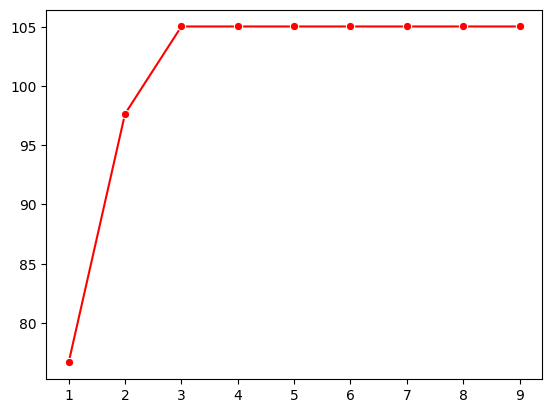

In [10]:
numbers= []
mobjvals=[]
for K in range(1, 10):
    _, mobjval=mclp(bus_points, train_points, apt_points, K, 1000)
    numbers.append(K)
    mobjvals.append(mobjval)

import seaborn as sns
import matplotlib.pyplot as plt

x= numbers
y= mobjvals

fig = plt.figure()
fig.set_facecolor('white')
# 선 그래프 한개 그리기
sns.lineplot(x=x, y=y, 
             color='r', # 색상
             linestyle='-', # 라인 스타일
             marker='o') # 마커

In [11]:
opts_sites, mobjVal = mclp(bus_points, train_points,apt_points, 3, 1000)
opts_sites

  K 3
  Radius 1000
----- Output -----
  Running time : 0.15610957145690918 seconds
Optimal coverage points: 105.026


array([[ 37.45002923, 126.70079475],
       [ 37.44016417, 126.70748765],
       [ 37.45317448, 126.72027743]])

In [12]:
df= pd.DataFrame(data= opts_sites, columns=['위도','경도'])
df.to_csv('교육 공모전 자료/구월동_최종입지.csv')

### 2. 논현동

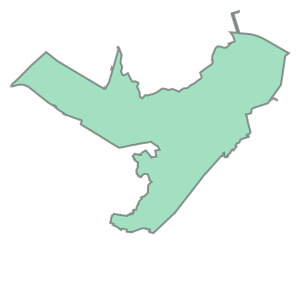

In [32]:
path= 'C:/Users/chldy/OneDrive/바탕 화면/용용/딥러닝 부트캠프/교육데이터공모전/shp_file/'
ex= path+'행정구역_읍면동.shp'
gpff= gpd.read_file(ex)
gpff['geometry'][32]

In [33]:
#랜덤 좌표 생성
def generate_candidate_sites_from_shp(shp_file_path, exclusion_shp_paths, M=100):
    # 대상 .shp 파일에서 폴리곤 불러오기
    random.seed(42)
    gdf = gpd.read_file(shp_file_path)
    poly = gdf['geometry'][32]  # 대상 폴리곤 추출
    
    #제외할 .shp 파일들에서 폴리곤들 불러오기
    ex_poligon_list=[]
    for ex_path in exclusion_shp_paths:
        ex= gpd.read_file(ex_path)
        for ex_poly in ex['geometry']:
            ex_poligon_list.append(ex_poly)
    
    

    min_x, min_y, max_x, max_y = poly.bounds
    sites = []
    attempts = 0  # 시도 횟수
    while len(sites) < M:
        random_point = Point(random.uniform(min_x, max_x),
                             random.uniform(min_y, max_y))
        
        # 진행도 체크
        if attempts % 1000 == 0:  # 100번의 시도마다 진행 상황 출력
            print(f"시도 횟수: {attempts}, 유효한 사이트 수: {len(sites)}")

        # 대상 폴리곤 내에 있고 제외할 폴리곤들 내에 없는지 확인
        if random_point.within(poly) :
            if not any(random_point.within(ex_poly) for ex_poly in ex_poligon_list):
                sites.append(random_point)
        attempts += 1  # 시도 횟수 증가

    return np.array([(p.x, p.y) for p in sites])

# 사용 예시
path= 'C:/Users/chldy/OneDrive/바탕 화면/용용/딥러닝 부트캠프/교육데이터공모전/shp_file/'
shp_file_path = path+'행정구역_읍면동.shp'
exclusion_shp_paths = [path+'상습침수구역.shp', path+'개발제한구역.shp', path+'공항_소음대책지역.shp']  # 제외할 .shp 파일들의 경로 리스트
M = 200  # 생성할 좌표 수
sites = generate_candidate_sites_from_shp(shp_file_path, exclusion_shp_paths ,M)

sites_df= pd.DataFrame(data=sites, columns=['경도','위도'])
sites_df



시도 횟수: 0, 유효한 사이트 수: 0


,경도,위도
0,174772.579059,531640.759257
1,176117.633620,534070.635496
2,173583.773605,534279.707665
3,176033.848979,533221.080633
4,176106.723601,534373.410104
...,...,...
195,174876.918600,533784.366092
196,173486.904306,534361.755894
197,174469.410561,534149.453395
198,174165.990178,533700.506654


In [34]:
from pyproj import Proj, transform

# 좌표 변환 함수 정의
def convert_coords(x, y):
    proj_UTM = Proj(init='epsg:5186')  # 원본 좌표계
    proj_WGS84 = Proj(init='epsg:4326')  # 목표 좌표계
    lon, lat = transform(proj_UTM, proj_WGS84, x, y)
    return pd.Series([lat, lon])

    # 새로운 'latitude'와 'longitude' 컬럼을 생성하고 변환된 좌표를 적용
sites_df[['latitude', 'longitude']] = sites_df.apply(lambda row: convert_coords(row['경도'], row['위도']), axis=1)

print(sites_df)

c:\Users\chldy\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\chldy\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\chldy\AppData\Local\Temp\ipykernel_18120\519013629.py:7: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pypro

                경도             위도   latitude   longitude
0    174772.579059  531640.759257  37.383756  126.715145
1    176117.633620  534070.635496  37.405685  126.730254
2    173583.773605  534279.707665  37.407500  126.701628
3    176033.848979  533221.080633  37.398028  126.729336
4    176106.723601  534373.410104  37.408413  126.730121
..             ...            ...        ...         ...
195  174876.918600  533784.366092  37.403073  126.716251
196  173486.904306  534361.755894  37.408237  126.700531
197  174469.410561  534149.453395  37.406351  126.711636
198  174165.990178  533700.506654  37.402298  126.708224
199  174549.711895  534402.873836  37.408637  126.712534

[200 rows x 4 columns]


In [35]:
# 아파트 좌표
apt= pd.read_csv('교육 공모전 자료/인천_아파트.csv')
apt.drop(['Unnamed: 0'], axis=1, inplace=True)
apt= apt[apt['legal_dong']=='논현동']
apt_points= np.array([list(i) for i in zip (apt['la'],apt['lo'])])
apt_points

array([[ 37.41076485, 126.71181233],
       [ 37.40803981, 126.71283252],
       [ 37.41001956, 126.71439896],
       [ 37.39622826, 126.73361827],
       [ 37.39341601, 126.73042395],
       [ 37.4033544 , 126.71290753],
       [ 37.40263284, 126.715651  ],
       [ 37.40330503, 126.71771841],
       [ 37.40146983, 126.71874111],
       [ 37.40703319, 126.73116178],
       [ 37.39805429, 126.73129839],
       [ 37.39948042, 126.73307378],
       [ 37.40348158, 126.72910294],
       [ 37.40556447, 126.73297849],
       [ 37.40589077, 126.7291178 ],
       [ 37.40564373, 126.72766555],
       [ 37.38646487, 126.72290085],
       [ 37.39270247, 126.72527786],
       [ 37.40413333, 126.72196874],
       [ 37.40613225, 126.72260179],
       [ 37.40164514, 126.73789219],
       [ 37.40265906, 126.73894862],
       [ 37.40278042, 126.73753331],
       [ 37.40432123, 126.73758446],
       [ 37.40703807, 126.73495446],
       [ 37.41300629, 126.71210186],
       [ 37.40006284, 126.73021078],
 

In [36]:
# 지하철 좌표
train= pd.read_csv('교육 공모전 자료/인천_지하철역.csv')
train.drop(['Unnamed: 0'],axis=1)
train= train[train['legal_dong']=='논현동']
train_points= np.array([list(i) for i in zip (train['lon'],train['lat'])])
train_points


array([], dtype=float64)

In [37]:
#버스 정류장 좌표
bus= pd.read_csv('교육 공모전 자료/인천_버스정류장.csv')
bus.drop(['Unnamed: 0'],axis=1, inplace=True)
bus= bus[bus['legal_dong']=='논현동']
bus_points= np.array([list(i) for i in zip (bus['위도'],bus['경도'])])
bus_points


array([[ 37.4023333, 126.7186667],
       [ 37.4025167, 126.7185167],
       [ 37.4036167, 126.7228   ],
       [ 37.4035167, 126.7222167],
       [ 37.4093667, 126.7107833],
       [ 37.4093333, 126.7114333],
       [ 37.4046167, 126.7274833],
       [ 37.40475  , 126.7277833],
       [ 37.4130333, 126.7028   ],
       [ 37.4018833, 126.7400167],
       [ 37.4028667, 126.74035  ],
       [ 37.4041833, 126.7368   ],
       [ 37.4043   , 126.7371333],
       [ 37.4051   , 126.7359667],
       [ 37.4063   , 126.7317333],
       [ 37.4052667, 126.7361167],
       [ 37.40685  , 126.7333   ],
       [ 37.40645  , 126.7343   ],
       [ 37.4066167, 126.7234   ],
       [ 37.4072167, 126.7229   ],
       [ 37.4061   , 126.72635  ],
       [ 37.4062833, 126.7264333],
       [ 37.4101667, 126.7352833],
       [ 37.4103167, 126.7351   ],
       [ 37.4063333, 126.73215  ],
       [ 37.4041   , 126.7308333],
       [ 37.4041833, 126.7311167],
       [ 37.4029   , 126.7298833],
       [ 37.40275  ,

#### 최적의 입지 개수

  K 1
  Radius 1000
----- Output -----
  Running time : 0.1661078929901123 seconds
Optimal coverage points: 53.299
  K 2
  Radius 1000
----- Output -----
  Running time : 0.16202998161315918 seconds
Optimal coverage points: 73.926
  K 3
  Radius 1000
----- Output -----
  Running time : 0.15500879287719727 seconds
Optimal coverage points: 89.102
  K 4
  Radius 1000
----- Output -----
  Running time : 0.15299677848815918 seconds
Optimal coverage points: 92.191
  K 5
  Radius 1000
----- Output -----
  Running time : 0.15269827842712402 seconds
Optimal coverage points: 92.191
  K 6
  Radius 1000
----- Output -----
  Running time : 0.14899134635925293 seconds
Optimal coverage points: 92.191
  K 7
  Radius 1000
----- Output -----
  Running time : 0.14945626258850098 seconds
Optimal coverage points: 92.191
  K 8
  Radius 1000
----- Output -----
  Running time : 0.1509535312652588 seconds
Optimal coverage points: 92.191
  K 9
  Radius 1000
----- Output -----
  Running time : 0.1515135765075683

<Axes: >

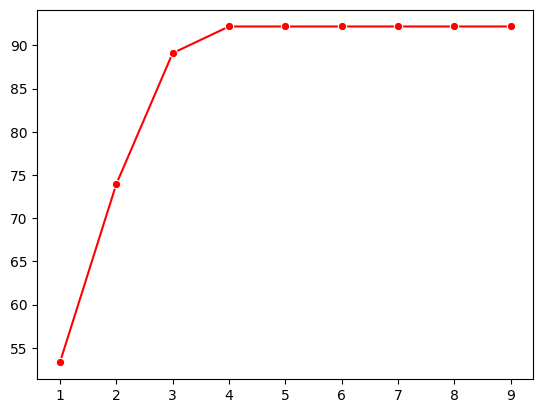

In [38]:
numbers= []
mobjvals=[]
for K in range(1, 10):
    _, mobjval=mclp(bus_points, train_points, apt_points, K, 1000)
    numbers.append(K)
    mobjvals.append(mobjval)

import seaborn as sns
import matplotlib.pyplot as plt

x= numbers
y= mobjvals

fig = plt.figure()
fig.set_facecolor('white')
# 선 그래프 한개 그리기
sns.lineplot(x=x, y=y, 
             color='r', # 색상
             linestyle='-', # 라인 스타일
             marker='o') # 마커

In [39]:
opts_sites, mobjVal = mclp(bus_points, train_points,apt_points, 3, 1000)
opts_sites

  K 3
  Radius 1000
----- Output -----
  Running time : 0.1569979190826416 seconds
Optimal coverage points: 89.102


array([[ 37.40535123, 126.73237655],
       [ 37.39177557, 126.72457971],
       [ 37.40744894, 126.70996698]])

In [40]:
df= pd.DataFrame(data= opts_sites, columns=['위도','경도'])
df.to_csv('교육 공모전 자료/논현동_최종입지.csv')

### 3. 만수동

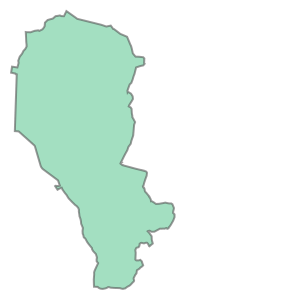

In [22]:
path= 'C:/Users/chldy/OneDrive/바탕 화면/용용/딥러닝 부트캠프/교육데이터공모전/shp_file/'
ex= path+'행정구역_읍면동.shp'
gpff= gpd.read_file(ex)
gpff['geometry'][2]

In [23]:
#랜덤 좌표 생성
def generate_candidate_sites_from_shp(shp_file_path, exclusion_shp_paths, M=100):
    # 대상 .shp 파일에서 폴리곤 불러오기
    random.seed(42)
    gdf = gpd.read_file(shp_file_path)
    poly = gdf['geometry'][2]  # 대상 폴리곤 추출
    
    # 제외할 .shp 파일들에서 폴리곤들 불러오기
    ex_poligon_list=[]
    for ex_path in exclusion_shp_paths:
        ex= gpd.read_file(ex_path)
        for ex_poly in ex['geometry']:
            ex_poligon_list.append(ex_poly)
    
    

    min_x, min_y, max_x, max_y = poly.bounds
    sites = []
    attempts = 0  # 시도 횟수
    while len(sites) < M:
        random_point = Point(random.uniform(min_x, max_x),
                             random.uniform(min_y, max_y))
        
        # 진행도 체크
        if attempts % 1000 == 0:  # 100번의 시도마다 진행 상황 출력
            print(f"시도 횟수: {attempts}, 유효한 사이트 수: {len(sites)}")

        # 대상 폴리곤 내에 있고 제외할 폴리곤들 내에 없는지 확인
        if random_point.within(poly) :
            if not any(random_point.within(ex_poly) for ex_poly in ex_poligon_list):
                sites.append(random_point)
        attempts += 1  # 시도 횟수 증가

    return np.array([(p.x, p.y) for p in sites])

# 사용 예시
path= 'C:/Users/chldy/OneDrive/바탕 화면/용용/딥러닝 부트캠프/교육데이터공모전/shp_file/'
shp_file_path = path+'행정구역_읍면동.shp'
exclusion_shp_paths = [path+'상습침수구역.shp', path+'개발제한구역.shp', path+'공항_소음대책지역.shp']  # 제외할 .shp 파일들의 경로 리스트
M = 200  # 생성할 좌표 수
sites = generate_candidate_sites_from_shp(shp_file_path, exclusion_shp_paths, M)
print(sites)

sites_df= pd.DataFrame(data=sites, columns=['경도','위도'])
sites_df



시도 횟수: 0, 유효한 사이트 수: 0
[[175881.9276196  539350.88744238]
 [175886.63385059 539723.23201156]
 [176299.37446592 539558.04930629]
 [176970.72468336 538727.3292283 ]
 [176008.13006369 541264.73793043]
 [175757.91955065 540343.8526842 ]
 [176765.1693868  540146.33240118]
 [175861.94211438 541292.49447247]
 [177022.29768405 538864.00012763]
 [176776.70462528 538274.31182658]
 [176837.32025293 541092.42585867]
 [175597.38682496 539892.65379483]
 [176007.73158201 539952.62870765]
 [176495.67374374 541340.88977811]
 [176618.0189848  537901.17148736]
 [176090.2819254  539943.69929727]
 [176900.98094881 537786.63042485]
 [175491.81761982 540483.52169627]
 [176551.95768388 539548.12265942]
 [176003.11434105 540979.7607963 ]
 [176719.08040361 540347.4215625 ]
 [176454.884634   539405.11500828]
 [176193.77340154 539718.98556661]
 [175496.46620661 539908.8810172 ]
 [175908.82811586 541126.13741311]
 [175932.4888007  540076.94700936]
 [176545.14014107 540590.09604722]
 [176416.97297393 539180.7988844

,경도,위도
0,175881.927620,539350.887442
1,175886.633851,539723.232012
2,176299.374466,539558.049306
3,176970.724683,538727.329228
4,176008.130064,541264.737930
...,...,...
195,176588.676758,538919.396647
196,176278.477065,539075.891565
197,175570.510617,540151.062741
198,176247.523905,538875.127998


In [24]:
from pyproj import Proj, transform

# 좌표 변환 함수 정의
def convert_coords(x, y):
    proj_UTM = Proj(init='epsg:5186')  # 원본 좌표계
    proj_WGS84 = Proj(init='epsg:4326')  # 목표 좌표계
    lon, lat = transform(proj_UTM, proj_WGS84, x, y)
    return pd.Series([lat, lon])

    # 새로운 'latitude'와 'longitude' 컬럼을 생성하고 변환된 좌표를 적용
sites_df[['latitude', 'longitude']] = sites_df.apply(lambda row: convert_coords(row['경도'], row['위도']), axis=1)

print(sites_df)

c:\Users\chldy\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\chldy\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\chldy\AppData\Local\Temp\ipykernel_18120\519013629.py:7: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pypro

                경도             위도   latitude   longitude
0    175881.927620  539350.887442  37.453255  126.727420
1    175886.633851  539723.232012  37.456609  126.727461
2    176299.374466  539558.049306  37.455132  126.732131
3    176970.724683  538727.329228  37.447664  126.739745
4    176008.130064  541264.737930  37.470502  126.728784
..             ...            ...        ...         ...
195  176588.676758  538919.396647  37.449385  126.735421
196  176278.477065  539075.891565  37.450787  126.731910
197  175570.510617  540151.062741  37.460456  126.723874
198  176247.523905  538875.127998  37.448977  126.731567
199  175639.875868  539613.682606  37.455616  126.724675

[200 rows x 4 columns]


c:\Users\chldy\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\chldy\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\chldy\AppData\Local\Temp\ipykernel_18120\519013629.py:7: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pypro

In [25]:
# 아파트 좌표
apt= pd.read_csv('교육 공모전 자료/인천_아파트.csv')
apt.drop(['Unnamed: 0'], axis=1, inplace=True)
apt= apt[apt['legal_dong']=='만수동']
apt_points= np.array([list(i) for i in zip (apt['la'],apt['lo'])])
apt_points

array([[ 37.44921966, 126.73295724],
       [ 37.45169949, 126.72648214],
       [ 37.45167541, 126.72677636],
       [ 37.45164405, 126.72707508],
       [ 37.45198231, 126.72749947],
       [ 37.46429623, 126.72313986],
       [ 37.43847555, 126.73717716],
       [ 37.45753859, 126.72485995],
       [ 37.44053721, 126.73959107],
       [ 37.44984664, 126.7392879 ],
       [ 37.4498875 , 126.73915775],
       [ 37.45843344, 126.73199056],
       [ 37.46253137, 126.73677108],
       [ 37.46386839, 126.73693583],
       [ 37.46358827, 126.73752636],
       [ 37.46395892, 126.7381234 ],
       [ 37.4644785 , 126.73833264],
       [ 37.46500354, 126.73853845],
       [ 37.46041175, 126.72832213],
       [ 37.46064217, 126.73010409],
       [ 37.46317302, 126.73127027],
       [ 37.46190307, 126.73758886],
       [ 37.46253751, 126.72409277],
       [ 37.46336014, 126.72453225],
       [ 37.45034383, 126.73391319],
       [ 37.44247487, 126.73497372],
       [ 37.44273797, 126.73494006],
 

In [26]:
# 지하철 좌표
train= pd.read_csv('교육 공모전 자료/인천_지하철역.csv')
train.drop(['Unnamed: 0'],axis=1)
train= train[train['legal_dong']=='만수동']
train_points= np.array([list(i) for i in zip (train['lon'],train['lat'])])
train_points


array([[ 37.44817192, 126.73663642],
       [ 37.45496238, 126.73190368]])

In [27]:
#버스 정류장 좌표
bus= pd.read_csv('교육 공모전 자료/인천_버스정류장.csv')
bus.drop(['Unnamed: 0'],axis=1, inplace=True)
bus= bus[bus['legal_dong']=='만수동']
bus_points= np.array([list(i) for i in zip (bus['위도'],bus['경도'])])
bus_points

array([[ 37.4394167, 126.7368   ],
       [ 37.4397   , 126.73785  ],
       [ 37.4422167, 126.73855  ],
       [ 37.4422833, 126.7388833],
       [ 37.4433167, 126.7362833],
       [ 37.4435333, 126.7366   ],
       [ 37.4457333, 126.7327833],
       [ 37.4445   , 126.7389167],
       [ 37.4446167, 126.7386333],
       [ 37.44675  , 126.7328167],
       [ 37.4483   , 126.7306667],
       [ 37.4486333, 126.7305   ],
       [ 37.4491667, 126.7294833],
       [ 37.4481667, 126.7331833],
       [ 37.44585  , 126.74055  ],
       [ 37.4485   , 126.7329   ],
       [ 37.4460167, 126.7407667],
       [ 37.4495833, 126.7297   ],
       [ 37.44805  , 126.7348   ],
       [ 37.4483833, 126.7349833],
       [ 37.4472167, 126.73985  ],
       [ 37.4504833, 126.7296167],
       [ 37.45045  , 126.7297833],
       [ 37.4474333, 126.7397333],
       [ 37.4490833, 126.7343667],
       [ 37.4479333, 126.7381833],
       [ 37.4482667, 126.7382667],
       [ 37.4517333, 126.72715  ],
       [ 37.4518667,

#### 최적의 입지 개수

  K 1
  Radius 1000
----- Output -----
  Running time : 0.18338632583618164 seconds
Optimal coverage points: 76.847
  K 2
  Radius 1000
----- Output -----
  Running time : 0.18498921394348145 seconds
Optimal coverage points: 109.46
  K 3
  Radius 1000
----- Output -----
  Running time : 0.17798447608947754 seconds
Optimal coverage points: 111.948
  K 4
  Radius 1000
----- Output -----
  Running time : 0.20000195503234863 seconds
Optimal coverage points: 111.948
  K 5
  Radius 1000
----- Output -----
  Running time : 0.1924905776977539 seconds
Optimal coverage points: 111.948
  K 6
  Radius 1000
----- Output -----
  Running time : 0.2629692554473877 seconds
Optimal coverage points: 111.948
  K 7
  Radius 1000
----- Output -----
  Running time : 0.19351577758789062 seconds
Optimal coverage points: 111.948
  K 8
  Radius 1000
----- Output -----
  Running time : 0.2020261287689209 seconds
Optimal coverage points: 111.948
  K 9
  Radius 1000
----- Output -----
  Running time : 0.17600131034

<Axes: >

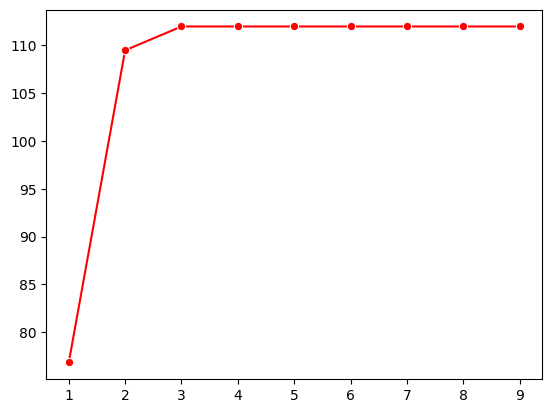

In [28]:
numbers= []
mobjvals=[]
for K in range(1, 10):
    _, mobjval=mclp(bus_points, train_points, apt_points, K, 1000)
    numbers.append(K)
    mobjvals.append(mobjval)

import seaborn as sns
import matplotlib.pyplot as plt

x= numbers
y= mobjvals

fig = plt.figure()
fig.set_facecolor('white')
# 선 그래프 한개 그리기
sns.lineplot(x=x, y=y, 
             color='r', # 색상
             linestyle='-', # 라인 스타일
             marker='o') # 마커

In [29]:
opts_sites, mobjVal = mclp(bus_points, train_points,apt_points, 2, 1000)
opts_sites

  K 2
  Radius 1000
----- Output -----
  Running time : 0.19100046157836914 seconds
Optimal coverage points: 109.46


array([[ 37.44564043, 126.73441567],
       [ 37.46075305, 126.73093135]])

In [31]:
df= pd.DataFrame(data= opts_sites, columns=['위도','경도'])
df.to_csv('교육 공모전 자료/만수동_최종입지.csv')